In [1]:
!pip install -q pandas scikit-learn joblib vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00


## YouTube 댓글 JSON 파일을 불러와 전처리하여 DataFrame으로 준비하는 코드

In [67]:
import os, json
import pandas as pd
from glob import glob

# JSONL 파일을 DataFrame으로 읽기
def load_jsonl(path):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

# JSON 배열을 DataFrame으로 읽기
def load_json_array(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return pd.DataFrame(data)

# 개별 JSON 파일({ ... } 형태)를 모아 DataFrame으로 읽기
def load_dir_of_json(dir_path):
    rows = []
    for fp in glob(os.path.join(dir_path, "*.json")):
        try:
            with open(fp, "r", encoding="utf-8") as f:
                obj = json.load(f)
                rows.append(obj)
        except Exception as e:
            print(f"[WARN] skip {fp}: {e}")
    return pd.DataFrame(rows)

# 댓글 파일 로드
df = load_json_array("/content/youtube_comments.json") #파일의 경로를 json형태로.

# text 값이 없는 행 제거
df = df.dropna(subset=["text"])

# text와 video_id 컬럼을 문자열로 변환
df["text"] = df["text"].astype(str)
df["video_id"] = df.get("video_id", pd.Series(["unknown"]*len(df))).astype(str)

df.head()


,video_id,comment_id,text,published_at
0,--1Hln74Ano,UgxsP-DtNzP_iPOxy2d4AaABAg,Biden should breathe a sigh of relief for the ...,2024-11-26T23:56:05Z
1,--1Hln74Ano,UgwKyveThVvLBaWvfLB4AaABAg,shes still the media darling,2024-11-26T23:57:39Z
2,--1Hln74Ano,UgzD9dxnPWE7q4UojsR4AaABAg,Abdul Kamal go join dharin stone in Italy 😊,2024-11-26T23:57:06Z
3,--1Hln74Ano,UgyVhQMNyOKCHXg05_d4AaABAg,We dodged a huge bullet by not having her win ...,2024-11-26T22:31:17Z
4,--1Hln74Ano,UgwMcLH63OgiuwF_oRp4AaABAg,"No one is above the law!! “For my friends, eve...",2024-11-26T23:56:29Z


## 댓글 텍스트에 확장 VADER++ 감성 분석을 적용하여 각 댓글의 감성 라벨(positive/neutral/negative)과 점수를 계산하고, 라벨별 개수와 비율을 집계하는 코드

In [70]:
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 기본 VADER 감성 분석기 초기화
analyzer = SentimentIntensityAnalyzer()

# 긍정/부정 이모지 목록
EMOJI_POS = set("😀😃😄😁😆😊😍👍🥰😂🤣❤️💕✨🎉😌🙂😉😺")
EMOJI_NEG = set("😠😡🤬💢👎😞😢😭💔😤😫😖🤮🙁☹️😿")

# ✅ 이모티콘 패턴 수정 (괄호/슬래시 이스케이프 정정)
EMOTICON_POS_PATTERNS = [
    r":\)",        # :)
    r":-?\)",      # :-) or :)
    r";\)",        # ;)
    r":D", r"=D"   # :D, =D
]
EMOTICON_NEG_PATTERNS = [
    r":\(",        # :(
    r":-?\(",      # :-( or :(
    r":'\(",       # :'(
    r":\/",        # :/
    r">:\("        # >:(
]

# 정규식 패턴 사전 컴파일
EMOTICON_POS = [re.compile(p) for p in EMOTICON_POS_PATTERNS]
EMOTICON_NEG = [re.compile(p) for p in EMOTICON_NEG_PATTERNS]

# 부정어 / 강조어 / 완화어 / 기타 텍스트 패턴
NEGATIONS = re.compile(
    r"\b(no|not|never|none|nothing|nowhere|hardly|scarcely|barely|"
    r"don’t|doesn’t|didn’t|isn’t|aren’t|won’t|can’t|couldn’t|shouldn’t)\b",
    re.I,
)
INTENSIFIERS = re.compile(r"\b(so|very|really|extremely|super|totally|highly|absolutely|incredibly)\b", re.I)
DOWNTONERS   = re.compile(r"\b(slightly|a\s*bit|kinda|sort\s*of|somewhat|fairly)\b", re.I)
ELONGATED    = re.compile(r"(.)\1{2,}")        #반복문자
ALLCAPS_WORD = re.compile(r"\b[A-Z]{3,}\b")    #대문자 단

def vader_plus_plus(
    text: str,
    pos_th=0.25, neg_th=-0.25,
    neutral_floor=0.15,
    emo_boost=0.08,
    emoticon_boost=0.06,
    excl_unit=0.02, excl_cap=0.10,
    qmark_penalty=0.01,
    elongated_boost=0.03,
    caps_boost=0.03,
    intensifier_boost=0.02,
    downtoner_damp=0.02
):
    """VADER 점수 + 이모지/이모티콘/문자 패턴 기반 보정"""
    t = text or ""
    s = analyzer.polarity_scores(t)
    c = s["compound"]

    # 구두점/대문자/반복문자
    exclam = t.count("!")
    c += min(excl_unit * exclam, excl_cap) * (1 if c >= 0 else -1)

    # 물음표 과다 사용 시 감정 강도 감소
    qmarks = t.count("?")
    if qmarks >= 2:
        c *= max(0.0, 1.0 - qmark_penalty * (qmarks - 1))

    # 반복 문자(+/- 보정)
    if ELONGATED.search(t):
        c += elongated_boost * (1 if c >= 0 else -1)

    #대문자 단어 보정
    caps_count = len(ALLCAPS_WORD.findall(t))
    if caps_count:
        c += min(caps_boost * caps_count, 0.12) * (1 if c >= 0 else -1)

    # 이모지 보정
    c += emo_boost * sum(ch in EMOJI_POS for ch in t)
    c -= emo_boost * sum(ch in EMOJI_NEG for ch in t)

    # 이모티콘 보정
    if any(p.search(t) for p in EMOTICON_POS):
        c += emoticon_boost
    if any(p.search(t) for p in EMOTICON_NEG):
        c -= emoticon_boost

    # 강조어/약화어
    intens_n = len(INTENSIFIERS.findall(t))
    down_n   = len(DOWNTONERS.findall(t))
    c += intensifier_boost * intens_n * (1 if c >= 0 else -1)
    c -= downtoner_damp   * down_n   * (1 if c >= 0 else -1)

    # 부정어 있으면 경계 넓힘
    if NEGATIONS.search(t):
        pos_th = max(pos_th, 0.30)
        neg_th = min(neg_th, -0.30)

    #점수 범위 제한
    c = float(max(min(c, 1.0), -1.0))

    #최종 라벨 결정
    if abs(c) < neutral_floor:
        return "neutral", c
    if c >= pos_th:
        return "positive", c
    if c <= neg_th:
        return "negative", c
    return "neutral", c

#label, label_score 컬럼 생성
df["label"], df["label_score"] = zip(*df["text"].astype(str).apply(vader_plus_plus))


# 라벨별 개수와 비율을 표 형태로 출력
label_counts = (
    df["label"]
    .value_counts()
    .rename_axis("label")
    .reset_index(name="count")
)

# 비율(%) 추가
label_counts["percentage"] = (label_counts["count"] / len(df) * 100).round(2)

print(label_counts)



      label  count  percentage
0  positive  29903       41.68
1   neutral  22446       31.28
2  negative  19401       27.04


## 감성 분석 라벨 데이터로 TF-IDF + 로지스틱 회귀 모델을 학습하고 성능을 평가한 뒤 학습된 파이프라인을 저장하는 코드

In [71]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, joblib

# === X(텍스트), y(라벨), groups(video_id) 준비
X = df["text"].astype(str).values
y = df["label"].astype(str).values
groups = df["video_id"].astype(str).values

# === video_id 기준 그룹 단위 학습/테스트 분할 (80% / 20%)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# === TF-IDF + 로지스틱 회귀 파이프라인
pipe = Pipeline([
    # 1~2그램 TF-IDF 벡터화 (sublinear_tf로 로그 스케일 보정)
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=1,
        max_df=1.0,
        sublinear_tf=True,
        strip_accents="unicode"
    )),
    # 불균형 데이터 대응(class_weight="balanced")
    ("clf", LogisticRegression(
        solver="liblinear",
        penalty="l2",
        C=0.5,
        class_weight="balanced",
        max_iter=500,
        random_state=42
    ))
])

# === 모델 학습
pipe.fit(X_train, y_train)

# === 예측
y_pred = pipe.predict(X_test)

# === 성능 평가 (정밀도, 재현율, F1)
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    labels=["negative","neutral","positive"],
    digits=4,
    zero_division=0
))

# === 혼동 행렬 출력 (행=정답, 열=예측)
print("\nConfusion Matrix (rows=true, cols=pred):")
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=["negative","neutral","positive"]),
    index=["true_negative","true_neutral","true_positive"],
    columns=["pred_negative","pred_neutral","pred_positive"]
))

# === 학습된 파이프라인 저장
joblib.dump(pipe, "sentiment_pipeline.joblib")
print("\nSaved model → sentiment_pipeline.joblib")



Classification Report:
              precision    recall  f1-score   support

    negative     0.7145    0.7232    0.7188      3797
     neutral     0.6419    0.6536    0.6477      4457
    positive     0.7901    0.7736    0.7818      6096

    accuracy                         0.7230     14350
   macro avg     0.7155    0.7168    0.7161     14350
weighted avg     0.7241    0.7230    0.7235     14350


Confusion Matrix (rows=true, cols=pred):
               pred_negative  pred_neutral  pred_positive
true_negative           2746           643            408
true_neutral             699          2913            845
true_positive            398           982           4716

Saved model → sentiment_pipeline.joblib


## 저장해 둔 감성 분석 파이프라인을 불러와 모델이 학습한 감성 라벨 목록을 확인하는 코드

In [72]:
import numpy as np
import joblib

# 저장된 감성 분석 파이프라인 로드
pipe = joblib.load("sentiment_pipeline.joblib")

# 분류기의 학습된 클래스(라벨) 목록 추출
classes = pipe.named_steps["clf"].classes_.tolist()

# 클래스 목록 확인
classes

['negative', 'neutral', 'positive']

## 저장된 감성 분석 모델을 사용해 단일 문장의 감정을 예측하고 확률 분포를 확인하는 코드

In [74]:
# 단일 문장 감성 예측

text = "this is so fun"  # 분석할 문장 입력

# 각 클래스별 예측 확률 계산
proba = pipe.predict_proba([text])[0]

# 가장 높은 확률의 클래스 선택
pred  = classes[int(np.argmax(proba))]

#결과 출력
dict(
    label=pred,
    probs={c: float(p) for c, p in zip(classes, proba)}
)


{'label': 'positive',
 'probs': {'negative': 0.2626629083208639,
  'neutral': 0.09283782144917002,
  'positive': 0.644499270229966}}

## 데이터 전체에 대해 감성 분석 모델을 적용하여 예측 라벨과 신뢰도를 원본 데이터프레임에 추가하는 코드

In [75]:
# 배치 예측: 원본 데이터프레임에 결과 추가

# 각 텍스트에 대한 클래스별 예측 확률 (배열 형태)
probas = pipe.predict_proba(df["text"].astype(str))

# 가장 확률이 높은 클래스 인덱스
preds  = probas.argmax(axis=1)

# 원본 DataFrame 복사 후 결과 컬럼 추가
df_out = df.copy()
df_out["label"] = [classes[i] for i in preds]   # 예측 라벨
df_out["conf"]  = probas.max(axis=1)            # 해당 라벨의 확률(신뢰도)

# 주요 컬럼만 확인 (상위 10개 행)
df_out[["video_id","comment_id","text","label","conf"]].head(10)


,video_id,comment_id,text,label,conf
0,--1Hln74Ano,UgxsP-DtNzP_iPOxy2d4AaABAg,Biden should breathe a sigh of relief for the ...,positive,0.599883
1,--1Hln74Ano,UgwKyveThVvLBaWvfLB4AaABAg,shes still the media darling,neutral,0.445241
2,--1Hln74Ano,UgzD9dxnPWE7q4UojsR4AaABAg,Abdul Kamal go join dharin stone in Italy 😊,neutral,0.424021
3,--1Hln74Ano,UgyVhQMNyOKCHXg05_d4AaABAg,We dodged a huge bullet by not having her win ...,positive,0.470921
4,--1Hln74Ano,UgwMcLH63OgiuwF_oRp4AaABAg,"No one is above the law!! “For my friends, eve...",negative,0.409939
5,--1Hln74Ano,Ugwx55BWC4CyIO4ISO94AaABAg,I was sent adult prison USA 🇺🇸 at 15yrs old. F...,negative,0.437991
6,--1Hln74Ano,UgxkV9zV-CAouD_fHQx4AaABAg,We do not want to see Kamala Harris in any for...,neutral,0.478962
7,--1Hln74Ano,UgxH6OYMVz9Q189bBbB4AaABAg,Common sense would tell you that Harris is don...,negative,0.490281
8,--1Hln74Ano,Ugy15xkfpfkxsqInDoZ4AaABAg,Kamala is now unburdened by the past.,neutral,0.581027
9,--1Hln74Ano,Ugyp4G_7OfpPeXH3W0x4AaABAg,Do not pardon Hunter!,neutral,0.474589


 ## 예측된 감성 라벨 분포를 막대그래프로 시각화하는 코드

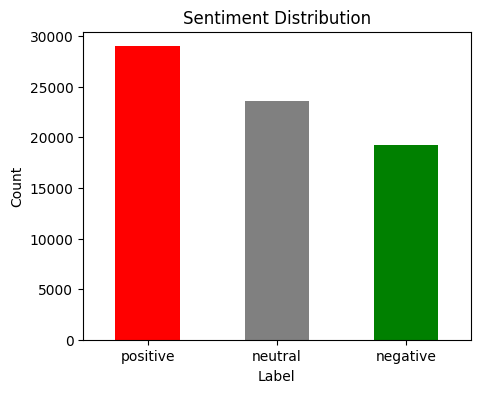

In [76]:
import matplotlib.pyplot as plt

df_out = df_out.rename(columns={"conf": "confidence"})

# === 1. 클래스별 개수 막대그래프 ===
plt.figure(figsize=(5,4))
df_out["label"].value_counts().plot(
    kind="bar",
    color=["red","gray","green"]  # negative, neutral, positive 색상
)
plt.title("Sentiment Distribution")  # 그래프 제목
plt.xlabel("Label")                  # x축 라벨
plt.ylabel("Count")                  # y축 라벨
plt.xticks(rotation=0)                # x축 라벨 회전 방지
plt.show()

## 감성 분석 예측의 신뢰도(confidence) 분포를 히스토그램으로 시각화하는 코드

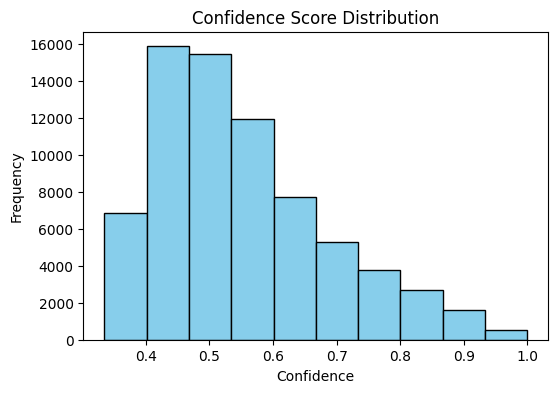

In [77]:
# 2. 신뢰도 히스토그램
plt.figure(figsize=(6,4))
plt.hist(df_out["confidence"], bins=10, color="skyblue", edgecolor="black")
plt.title("Confidence Score Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.show()

# 각 감성 라벨별 평균 신뢰도(confidence)를 가로 막대그래프로 시각화하는 코드

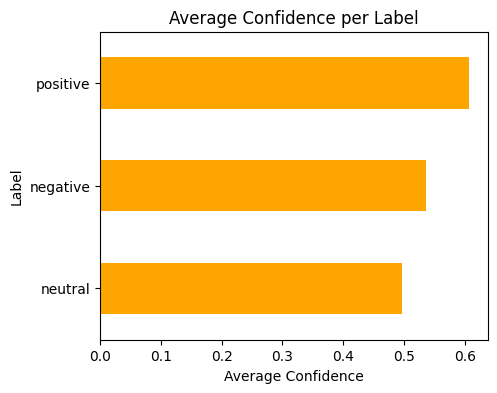

In [78]:
# 3. 클래스별 평균 신뢰도
plt.figure(figsize=(5,4))
df_out.groupby("label")["confidence"].mean().sort_values().plot(kind="barh", color="orange")
plt.title("Average Confidence per Label")
plt.xlabel("Average Confidence")
plt.ylabel("Label")
plt.show()

# 감성 분석 모델 예측 결과(라벨·신뢰도)를 데이터에 추가하고 CSV랑 JSON형식으로 저장

In [81]:
import os, json

# 저장 폴더 경로
save_dir = "/content/output"
os.makedirs(save_dir, exist_ok=True)  # 폴더 없으면 생성

# === 예측 확률과 레이블 부착 ===
probas = pipe.predict_proba(df["text"].astype(str))
classes = pipe.named_steps["clf"].classes_.tolist()
pred_idx = probas.argmax(axis=1)

df_out = df.copy()
df_out["label"] = [classes[i] for i in pred_idx]
df_out["confidence"] = probas.max(axis=1)

# === JSON 저장 ===
json_path = os.path.join(save_dir, "comments_with_sentiment.json")
with open(json_path, "w", encoding="utf-8") as w:
    json.dump(df_out.to_dict(orient="records"), w, ensure_ascii=False, indent=2)

# === CSV 저장 ===
csv_path = os.path.join(save_dir, "comments_with_sentiment.csv")
df_out.to_csv(csv_path, index=False, encoding="utf-8")

print(f"저장 완료 → {json_path}, {csv_path}")


저장 완료 → /content/output/comments_with_sentiment.json, /content/output/comments_with_sentiment.csv


## 결과를 다시 불러와서 개수 확인

In [80]:
import pandas as pd

# 저장된 CSV 불러오기
csv_path = "/content/output/comments_with_sentiment.csv"
df_loaded = pd.read_csv(csv_path)

# 라벨별 개수 확인
label_counts = df_loaded["label"].value_counts()
print(label_counts)

# 라벨별 비율(%)도 함께 확인
label_ratio = (label_counts / len(df_loaded) * 100).round(2)
print("\n라벨 비율(%)\n", label_ratio)


label
positive    28995
neutral     23551
negative    19204
Name: count, dtype: int64

라벨 비율(%)
 label
positive    40.41
neutral     32.82
negative    26.77
Name: count, dtype: float64
